<a href="https://colab.research.google.com/github/sibaysky/MarketSalesForecast/blob/main/DiplomSem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

Импорт pandas и numpy для работы с данными, а также LabelEncoder и StandardScaler из sklearn для предобработки.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn as nn

# Загрузка данных

Загрузка обучающего, тестового и справочных датасетов с помощью pandas.


In [ ]:
# Загрузка данных

from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

Mounted at /content/drive/


# Предобработка и агрегация данных

Агрегируем продажи по месяцам, ограничиваем значения, объединяем со справочниками.  
Создаем дополнительные признаки: средние продажи и цены, категориальные уровни, классы спроса и цен.  
Применяем кодирование категорий и стандартизацию числовых признаков для последующего использования в модели.


In [ ]:
# Агрегация: суммируем продажи по месяцам
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                         'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                         'item_price_mean', 'item_price_max']

# Ограничим продажи до [0, 20], как требует Kaggle
monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')

# Кодируем категориальные признаки
for col in ['shop_id', 'item_id', 'item_category_id']:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col])

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')

monthly_sales.rename(columns={'item_cnt_sum': 'target'}, inplace=True)
monthly_sales['log_target'] = np.log1p(monthly_sales['target'])

# Обработка текстов
def normalize_name(name):
    import re
    name = name.lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_sku_name'] = LabelEncoder().fit_transform(monthly_sales['normalized_sku_name'])

monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(lambda x: x.split(' ')[0])
monthly_sales['sku_level_1_category'] = LabelEncoder().fit_transform(monthly_sales['sku_level_1_category'])

monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 3, labels=False)
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 3, labels=False)

# Списки фичей
cat_features = ['item_id', 'item_category_id', 'normalized_sku_name',
                'sku_level_1_category', 'price_class', 'demand_class']

embed_sizes = {col: monthly_sales[col].nunique() for col in cat_features}
num_features = ['item_cnt_mean', 'item_cnt_count', 'item_price_mean',
                'item_price_max', 'item_avg_sales', 'item_avg_price', 'shop_avg_sales']

#Добавим стандартизацию числовых признаков
scaler = StandardScaler()
X_num = scaler.fit_transform(monthly_sales[num_features]).astype(np.float32)

X_cat = monthly_sales[cat_features].values.astype(np.int64)
y = monthly_sales['log_target'].values.astype(np.float32)

#Нормализуем цену
item_price = monthly_sales['item_price_mean'].clip(1e-2)  # избегаем log(0)
price_tensor = item_price.values / item_price.max()
price_tensor = price_tensor.astype(np.float32)

# Модель ElasticityModel

Определяем нейросетевую архитектуру на базе `nn.Module` для оценки эластичности спроса.  
Модель использует эмбеддинги категориальных признаков, полносвязный слой для числовых, и два линейных выхода:
- один для лог-спроса (baseline),
- второй — для лог-множителя эластичности (ограничен через tanh).

Финальный прогноз лог-спроса корректируется с учетом логарифма цены.


In [ ]:
class ElasticityModel(nn.Module):
    def __init__(self, embed_sizes, num_numerical):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(n, min(50, (n + 1) // 2)) for col, n in embed_sizes.items()
        })
        emb_dim = sum([emb.embedding_dim for emb in self.embeddings.values()])
        self.bn_num = nn.BatchNorm1d(num_numerical)
        self.fc_num = nn.Linear(num_numerical, 64)
        self.encoder_demand = nn.Linear(emb_dim + 64, 1)
        self.encoder_elasticity = nn.Linear(emb_dim + 64, 1)

    def forward(self, x_cat, x_num, log_price):
        x_emb = [self.embeddings[col](x_cat[:, i]) for i, col in enumerate(embed_sizes)]
        x_emb = torch.cat(x_emb, dim=1)
        x_num = self.bn_num(x_num)
        x_num_proj = F.relu(self.fc_num(x_num))
        x = torch.cat([x_emb, x_num_proj], dim=1)

        log_demand = self.encoder_demand(x)
        raw_mul = self.encoder_elasticity(x)

        # Ограничим log_mul от -5 до 5
        log_mul = 5.0 * torch.tanh(raw_mul)

        # Прогноз лог-спроса
        pred = log_demand - log_mul * log_price.view(-1, 1)
        return pred.squeeze()


# Обучение модели

Подготовка данных для обучения с использованием `TensorDataset` и `DataLoader`.  
Инициализация модели, оптимизатора (Adam) и функции потерь (MSE).  
Обучение проводится в течение 5 эпох с расчётом и выводом средней потери на каждой эпохе.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch

X_num_tensor = torch.tensor(X_num)
X_cat_tensor = torch.tensor(X_cat)
y_tensor = torch.tensor(y)
log_price_tensor = torch.tensor(np.log1p(price_tensor))

dataset = TensorDataset(X_cat_tensor, X_num_tensor, log_price_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

model = ElasticityModel(embed_sizes, X_num.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for x_cat_b, x_num_b, log_price_b, y_b in dataloader:
        optimizer.zero_grad()
        pred = model(x_cat_b, x_num_b, log_price_b)
        loss = loss_fn(pred, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_cat_b.size(0)
    print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader.dataset):.4f}")


NameError: name 'ElasticityModel' is not defined

# Визуализация кривых спроса

Строим кривые зависимости спроса от цены для первых 5 товаров.  
Для каждого товара варьируем цену и предсказываем спрос, отображая результаты на графике.


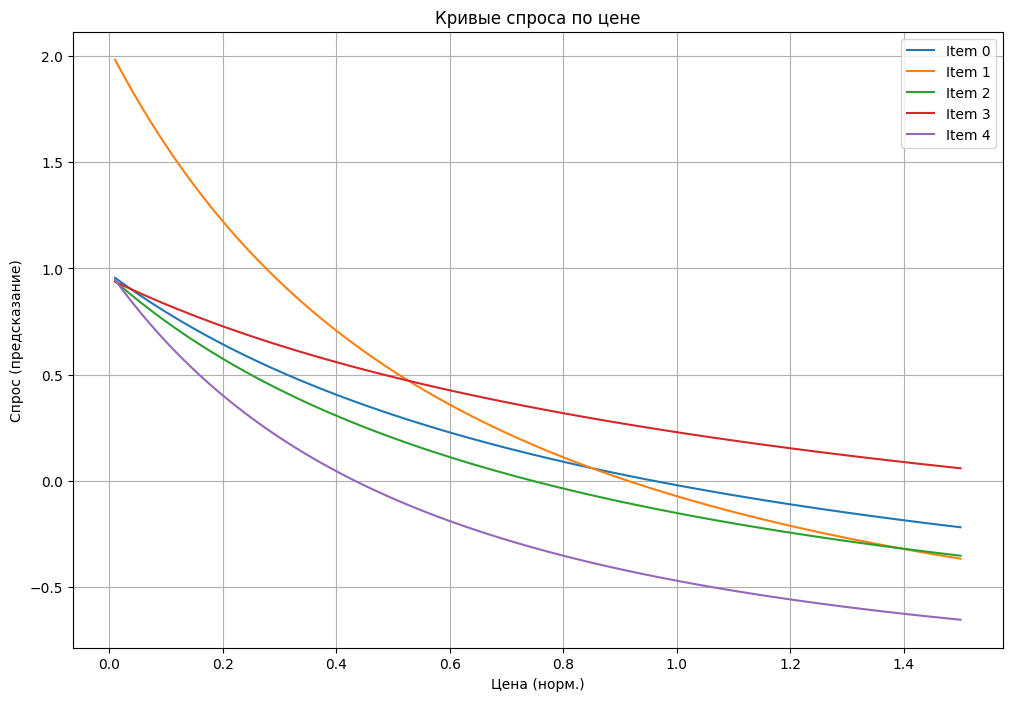

In [ ]:
import matplotlib.pyplot as plt

model.eval()
top_items = np.unique(X_cat_tensor[:, 0].numpy())[:5]  # первые 5 item_id (можно заменить на топ по продажам)

plt.figure(figsize=(12, 8))
for item_id in top_items:
    # Найдём первую строку с этим item_id
    idx = (X_cat_tensor[:, 0] == item_id).nonzero(as_tuple=True)[0][0]

    # Возьмём категориальные и числовые фичи
    x_cat_base = X_cat_tensor[idx].unsqueeze(0).repeat(100, 1)
    x_num_base = X_num_tensor[idx].unsqueeze(0).repeat(100, 1)

    # Разные цены в лог-пространстве
    prices = np.linspace(0.01, 1.5, 100)
    log_prices = torch.tensor(np.log1p(prices), dtype=torch.float32)

    preds = model(x_cat_base, x_num_base, log_prices).detach().numpy()
    demand = np.expm1(preds)  # переводим из log(1 + y)

    plt.plot(prices, demand, label=f"Item {item_id}")

plt.xlabel("Цена (норм.)")
plt.ylabel("Спрос (предсказание)")
plt.title("Кривые спроса по цене")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
elasticities = []
for i in range(len(X_cat_tensor)):
    with torch.no_grad():
        x_cat_b = X_cat_tensor[i].unsqueeze(0)
        x_num_b = X_num_tensor[i].unsqueeze(0)
        log_price_b = log_price_tensor[i].unsqueeze(0)

        x_emb = [model.embeddings[col](x_cat_b[:, j]) for j, col in enumerate(embed_sizes)]
        x_emb = torch.cat(x_emb, dim=1)
        x_num_proj = F.relu(model.fc_num(model.bn_num(x_num_b)))
        x = torch.cat([x_emb, x_num_proj], dim=1)

        elasticity = 5.0 * torch.tanh(model.encoder_elasticity(x))  # bounded
        elasticities.append(elasticity.item())

plt.hist(elasticities, bins=50)
plt.title("Распределение эластичности")
plt.xlabel("Эластичность")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

# Анализ распределения эластичности

Извлекаем значения эластичности из обученной модели для всех наблюдений.  
Строим гистограмму, чтобы визуализировать распределение эластичности спроса по товарам.


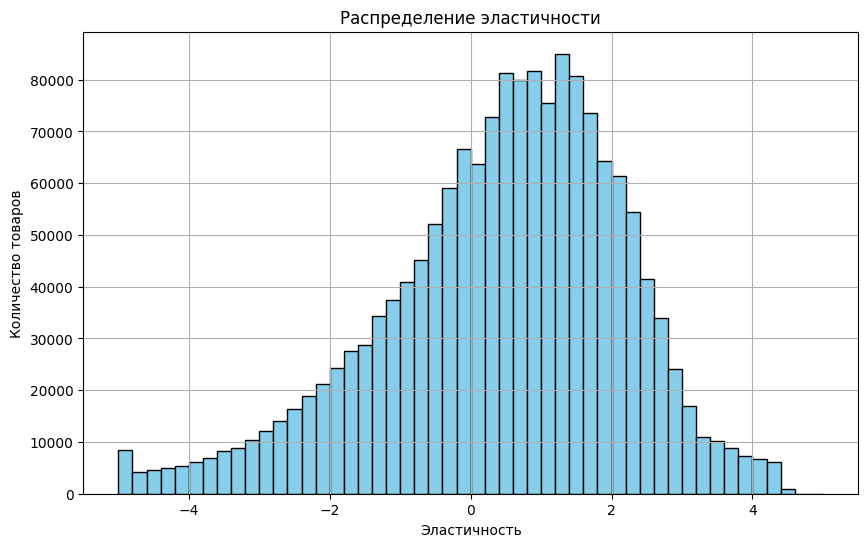

In [ ]:
import torch.nn.functional as F

# Получаем выходы модели
with torch.no_grad():
    # Прогоняем всё сразу
    x_emb = [model.embeddings[col](X_cat_tensor[:, j]) for j, col in enumerate(embed_sizes)]
    x_emb = torch.cat(x_emb, dim=1)
    x_num_proj = F.relu(model.fc_num(model.bn_num(X_num_tensor)))
    x = torch.cat([x_emb, x_num_proj], dim=1)

    elasticities = 5.0 * torch.tanh(model.encoder_elasticity(x)).squeeze().numpy()

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(elasticities, bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение эластичности")
plt.xlabel("Эластичность")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.show()


# Анализ кривых прибыли

На основе предсказанного спроса и заданной себестоимости рассчитываем прибыль для разных цен.  
Строим графики зависимости прибыли от цены для выбранных товаров.


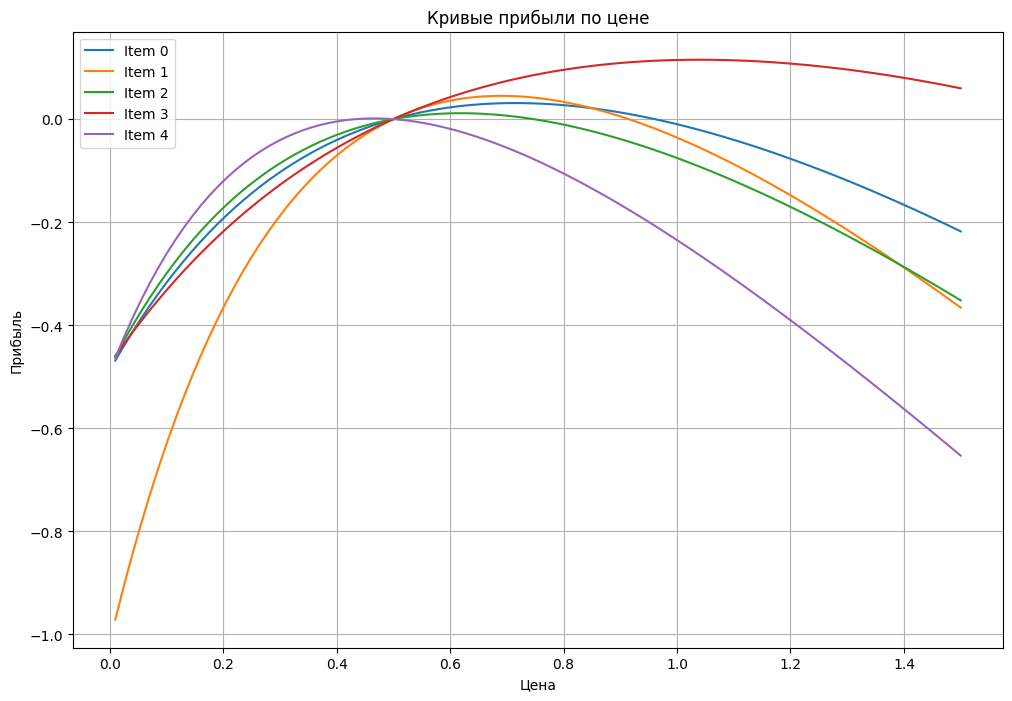

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Примерные значения себестоимости для каждого товара
costs = {item_id: 0.5 for item_id in top_items}  # Замените на реальные значения

plt.figure(figsize=(12, 8))
for item_id in top_items:
    # Найдём первую строку с этим item_id
    idx = (X_cat_tensor[:, 0] == item_id).nonzero(as_tuple=True)[0][0]

    # Возьмём категориальные и числовые фичи
    x_cat_base = X_cat_tensor[idx].unsqueeze(0).repeat(100, 1)
    x_num_base = X_num_tensor[idx].unsqueeze(0).repeat(100, 1)

    # Разные цены
    prices = np.linspace(0.01, 1.5, 100)
    log_prices = torch.tensor(np.log1p(prices), dtype=torch.float32)

    preds = model(x_cat_base, x_num_base, log_prices).detach().numpy()
    demand = np.expm1(preds)  # переводим из log(1 + y)

    profit = (prices - costs[item_id]) * demand
    plt.plot(prices, profit, label=f"Item {item_id}")

plt.xlabel("Цена")
plt.ylabel("Прибыль")
plt.title("Кривые прибыли по цене")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
1.  R^2 score
    спрос за предыдущие дни, сравнить ошибку. для тривиалиного и моего, одно на другое поделить
    MAPE
    на тестовой проверить

2. создать репозиторий. описать. в редми ход работ. главы

3. бустинг добавить. нир - спрос. практика - бустинг (катбуст)

коллаб, kaggle notebook

SyntaxError: invalid syntax (4281133360.py, line 1)

# Оценка качества модели

Определены функции для расчёта ключевых метрик качества:  
- R² (коэффициент детерминации)  
- MAE (средняя абсолютная ошибка)  
- MAPE (средняя абсолютная процентная ошибка)  

Функция `evaluate_metrics` выводит и возвращает значения метрик для удобства сравнения моделей.


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Функция для MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# Функция для расчета всех метрик
def evaluate_metrics(y_true, y_pred, name='Model'):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"[{name}] R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return r2, mae, mape


# Разделение данных на обучающую и тестовую выборки

Разбиваем данные в пропорции 80/20 для обучения и оценки модели.  
Создаем соответствующие `TensorDataset` и `DataLoader` для удобной подачи данных на обучение и тестирование.


In [ ]:
# Допустим 80% train, 20% test
from sklearn.model_selection import train_test_split

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, log_price_train, log_price_test = train_test_split(
    X_cat_tensor, X_num_tensor, y_tensor, log_price_tensor, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_cat_train, X_num_train, log_price_train, y_train)
test_dataset = TensorDataset(X_cat_test, X_num_test, log_price_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# Обучение модели на тренировочной выборке

Инициализация модели, оптимизатора и функции потерь.  
Обучение проводится в течение 5 эпох с подсчетом средней ошибки на тренировочных данных.


In [ ]:
model = ElasticityModel(embed_sizes, X_num.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for x_cat_b, x_num_b, log_price_b, y_b in train_loader:
        optimizer.zero_grad()
        pred = model(x_cat_b, x_num_b, log_price_b)
        loss = loss_fn(pred, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_cat_b.size(0)
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 0.0265
Epoch 2, Loss: 0.0051
Epoch 3, Loss: 0.0046
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0035


# Оценка модели на тестовой выборке

В режиме оценки получаем предсказания для тестовых данных и вычисляем ключевые метрики качества модели.


In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for x_cat_b, x_num_b, log_price_b, y_b in test_loader:
        pred = model(x_cat_b, x_num_b, log_price_b)
        y_pred.append(pred.cpu().numpy())
        y_true.append(y_b.cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

# Метрики модели
evaluate_metrics(y_true, y_pred, name='ElasticityModel')


[ElasticityModel] R2: 0.9886, MAE: 0.0274, MAPE: 2.82%


(0.9885522127151489, 0.02741941064596176, np.float32(2.8179493))

# Сравнение с тривиальным предиктором

Используем сдвинутые на один шаг истинные значения как базовый прогноз.  
Вычисляем метрики для тривиального предиктора и сравниваем с результатами модели.


In [ ]:
# Тривиальный предиктор: предполагаем что спрос такой же как вчера
y_trivial = np.roll(y_true, 1)
y_trivial[0] = y_trivial[1]  # чтобы не было мусора в начале

# Метрики тривиального
evaluate_metrics(y_true, y_trivial, name='Trivial Predictor')

# Сравнение
model_mape = mean_absolute_percentage_error(y_true, y_pred)
trivial_mape = mean_absolute_percentage_error(y_true, y_trivial)

print(f"Отношение ошибок: Моя модель / Тривиальный = {model_mape / trivial_mape:.4f}")


[Trivial Predictor] R2: -0.9974, MAE: 0.4011, MAPE: 39.38%
Отношение ошибок: Моя модель / Тривиальный = 0.0716


# Модель прогнозирования спроса с учетом ценовой эластичности

В данном ноутбуке реализована система прогнозирования спроса на товары с учетом влияния цены (ценовой эластичности). Подход основан на двухмодельной архитектуре:

1. **Базовая модель спроса** — предсказывает логарифм спроса без учета цены.
2. **Модель эластичности** — оценивает, как изменение цены влияет на спрос.

Модель обучается на исторических продажах и справочниках товаров и магазинов. Используются как числовые, так и категориальные признаки (включая текстовые иерархии и группировки).

Основные этапы:
- Загрузка и предобработка данных (`sales`, `items`, `categories`, `shops`, `test`)
- Инженерия признаков: агрегации, нормализация текстов, создание категорий
- Обучение двух моделей на основе LightGBM
- Визуализация кривых спроса для топ-товаров
- Анализ эластичности по категориям

Модель позволяет:
- Строить прогноз спроса при разных уровнях цены
- Выявлять категории с высокой или низкой чувствительностью к цене
- Использовать результаты для оптимизации цен и повышения прибыли


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Размер обучающей выборки: (1287299, 14)
Размер валидационной выборки: (321825, 14)
Обучение модели базового спроса...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.000203894
[200]	valid_0's l2: 4.59082e-05
[300]	valid_0's l2: 2.61983e-05
[400]	valid_0's l2: 2.04231e-05
[500]	valid_0's l2: 1.69729e-05
[600]	valid_0's l2: 1.53836e-05
[700]	valid_0's l2: 1.35918e-05
[800]	valid_0's l2: 1.2326e-05
[900]	valid_0's l2: 1.14499e-05
[1000]	valid_0's l2: 1.0584e-05
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.0584e-05

Обучение модели эластичности...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.22212e-06
[200]	valid_0's l2: 2.1402e-06
Early stopping, best iteration is:
[158]	valid_0's l2: 2.12026e-06

RMSE на обучении: 0.0029
RMSE на валидации: 0.0033

Важность при

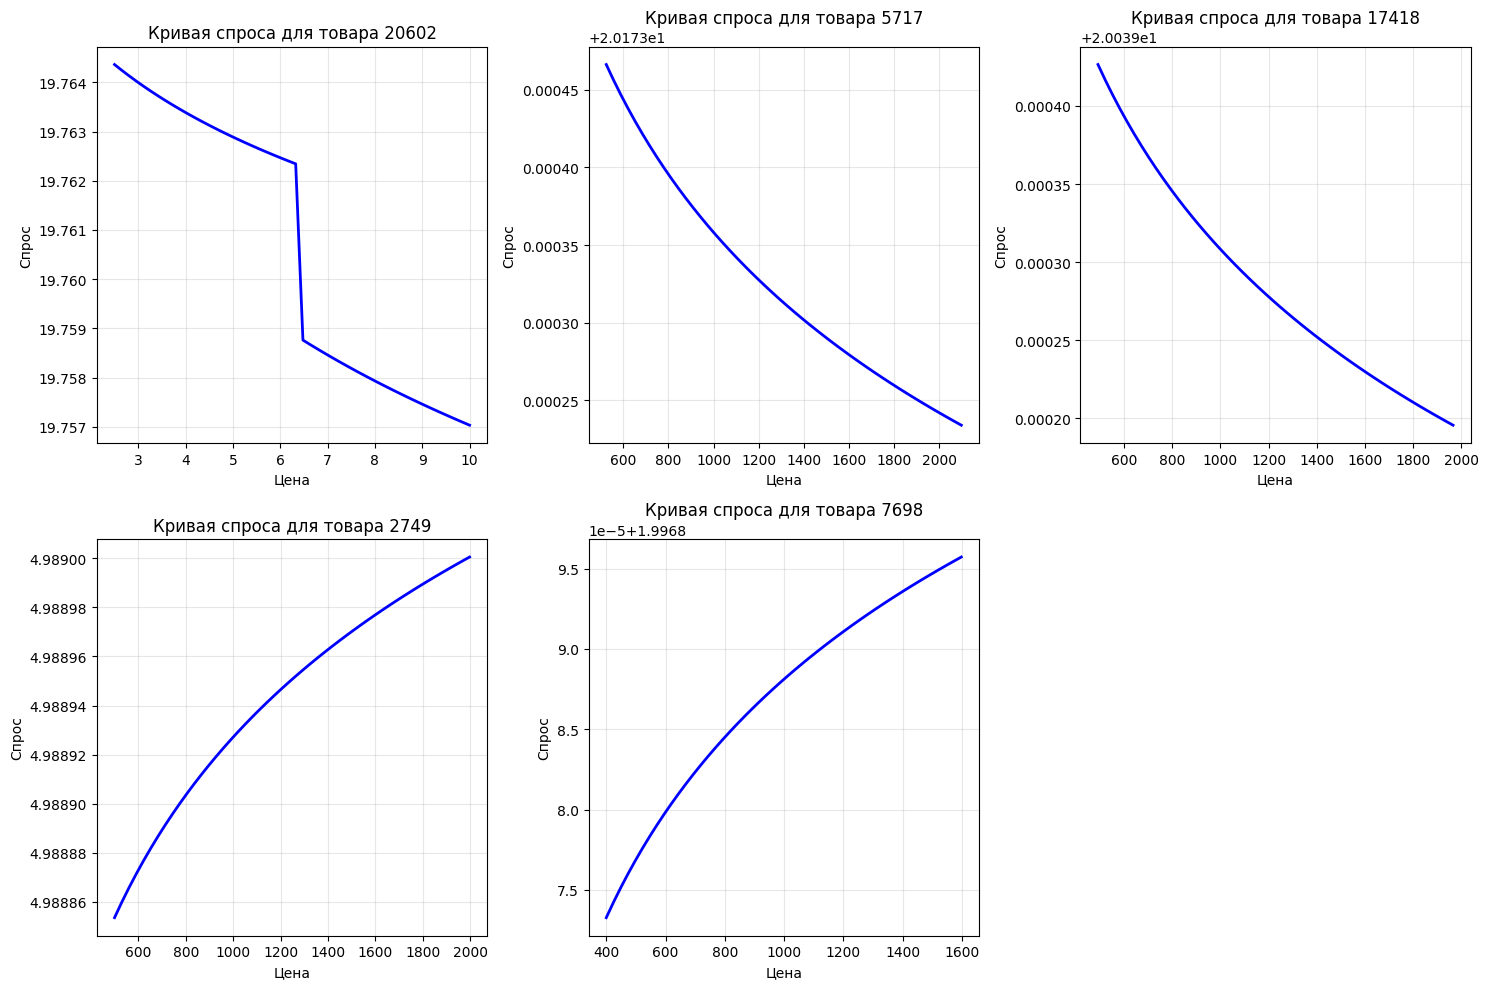

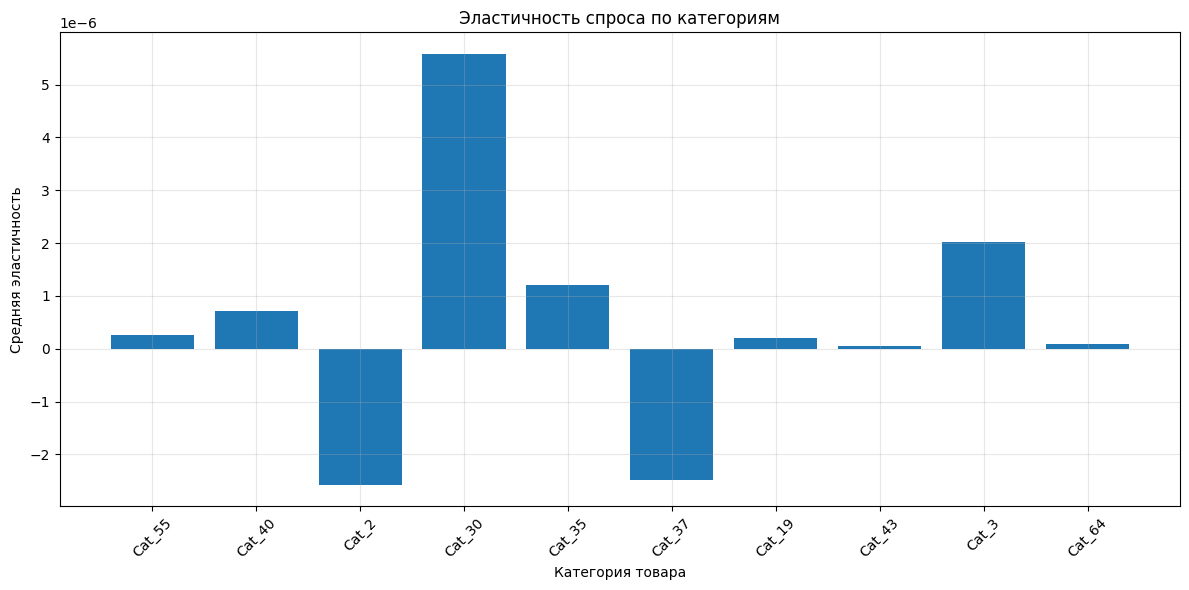


Модель обучена успешно!
Основные преимущества LightGBM подхода:
1. Быстрое обучение и предсказание
2. Хорошая работа с категориальными признаками
3. Встроенная регуляризация
4. Интерпретируемость через важность признаков
5. Robustness к выбросам


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Загрузка и подготовка данных (ваш существующий код)
from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

# Агрегация данных
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                        'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                        'item_price_mean', 'item_price_max']

monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')

# Кодируем категориальные признаки
label_encoders = {}
for col in ['shop_id', 'item_id', 'item_category_id']:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col])
    label_encoders[col] = le

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')

monthly_sales.rename(columns={'item_cnt_sum': 'target'}, inplace=True)
monthly_sales['log_target'] = np.log1p(monthly_sales['target'])

# Обработка текстов
def normalize_name(name):
    import re
    if pd.isna(name):
        return "unknown"
    name = name.lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_sku_name'] = LabelEncoder().fit_transform(monthly_sales['normalized_sku_name'])

monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else "unknown"
)
monthly_sales['sku_level_1_category'] = LabelEncoder().fit_transform(monthly_sales['sku_level_1_category'])

monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 3, labels=False, duplicates='drop')
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 3, labels=False, duplicates='drop')

# Подготовка данных для модели эластичности
# Создаем признаки для моделирования эластичности
monthly_sales['log_price'] = np.log1p(monthly_sales['item_price_mean'])

# Списки признаков
cat_features = ['item_id', 'item_category_id', 'normalized_sku_name',
                'sku_level_1_category', 'price_class', 'demand_class', 'shop_id']

num_features = ['item_cnt_mean', 'item_cnt_count', 'item_price_max',
                'item_avg_sales', 'item_avg_price', 'shop_avg_sales', 'log_price']

# Создаем финальный датасет
features = cat_features + num_features
X = monthly_sales[features].copy()
y = monthly_sales['log_target'].values

# Заполняем пропуски
for col in cat_features:
    X[col] = X[col].fillna(-1)
for col in num_features:
    X[col] = X[col].fillna(X[col].median())

# Разделение на train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

# Модель LightGBM для эластичности спроса
class ElasticityLGBMModel:
    def __init__(self):
        # Модель для базового спроса
        self.demand_model = lgb.LGBMRegressor(
            objective='regression',
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=63,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            verbose=-1
        )

        # Модель для коэффициента эластичности
        self.elasticity_model = lgb.LGBMRegressor(
            objective='regression',
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=4,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=0.5,
            random_state=42,
            verbose=-1
        )

        self.cat_features = cat_features

    def prepare_features_for_demand(self, X):
        """Подготовка признаков для модели базового спроса (без цены)"""
        X_demand = X.drop('log_price', axis=1)
        return X_demand

    def prepare_features_for_elasticity(self, X):
        """Подготовка признаков для модели эластичности"""
        return X.copy()

    def fit(self, X_train, y_train, X_val, y_val):
        print("Обучение модели базового спроса...")

        # Подготавливаем данные для модели спроса (без цены)
        X_train_demand = self.prepare_features_for_demand(X_train)
        X_val_demand = self.prepare_features_for_demand(X_val)

        # Обучаем модель базового спроса
        self.demand_model.fit(
            X_train_demand, y_train,
            eval_set=[(X_val_demand, y_val)],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
            categorical_feature=[col for col in self.cat_features if col != 'log_price']
        )

        # Получаем предсказания базового спроса
        demand_pred_train = self.demand_model.predict(X_train_demand)
        demand_pred_val = self.demand_model.predict(X_val_demand)

        print("\nОбучение модели эластичности...")

        # Подготавливаем target для модели эластичности
        # Эластичность = (реальный спрос - базовый спрос) / log_price
        elasticity_train = (y_train - demand_pred_train) / (X_train['log_price'] + 1e-8)
        elasticity_val = (y_val - demand_pred_val) / (X_val['log_price'] + 1e-8)

        # Ограничиваем эластичность разумными пределами
        elasticity_train = np.clip(elasticity_train, -5, 5)
        elasticity_val = np.clip(elasticity_val, -5, 5)

        # Обучаем модель эластичности
        self.elasticity_model.fit(
            X_train, elasticity_train,
            eval_set=[(X_val, elasticity_val)],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
            categorical_feature=self.cat_features
        )

    def predict(self, X, log_price=None):
        """Предсказание с учетом эластичности"""
        if log_price is None:
            log_price = X['log_price']

        # Предсказание базового спроса
        X_demand = self.prepare_features_for_demand(X)
        base_demand = self.demand_model.predict(X_demand)

        # Предсказание эластичности
        elasticity = self.elasticity_model.predict(X)

        # Итоговый прогноз с учетом цены
        final_prediction = base_demand + elasticity * log_price

        return final_prediction

    def predict_demand_curve(self, X_sample, price_range):
        """Построение кривой спроса для образца"""
        predictions = []

        for price in price_range:
            X_temp = X_sample.copy()
            X_temp['log_price'] = np.log1p(price)
            pred = self.predict(X_temp)
            predictions.append(pred)

        return np.array(predictions)

# Обучение модели
model = ElasticityLGBMModel()
model.fit(X_train, y_train, X_val, y_val)

# Оценка качества
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_rmse = np.sqrt(np.mean((y_train - train_pred)**2))
val_rmse = np.sqrt(np.mean((y_val - val_pred)**2))

print(f"\nRMSE на обучении: {train_rmse:.4f}")
print(f"RMSE на валидации: {val_rmse:.4f}")

# Важность признаков
print("\nВажность признаков для модели спроса:")
demand_importance = pd.DataFrame({
    'feature': model.demand_model.feature_name_,
    'importance': model.demand_model.feature_importances_
}).sort_values('importance', ascending=False)
print(demand_importance.head(10))

print("\nВажность признаков для модели эластичности:")
elasticity_importance = pd.DataFrame({
    'feature': model.elasticity_model.feature_name_,
    'importance': model.elasticity_model.feature_importances_
}).sort_values('importance', ascending=False)
print(elasticity_importance.head(10))

# Построение кривых спроса
plt.figure(figsize=(15, 10))

# Выбираем топ-5 товаров по продажам
top_items = monthly_sales.groupby('item_id')['target'].sum().nlargest(5).index

for i, item_id in enumerate(top_items):
    # Находим типичный образец этого товара
    item_data = X_val[X_val['item_id'] == item_id]
    if len(item_data) == 0:
        item_data = X_train[X_train['item_id'] == item_id]

    if len(item_data) > 0:
        sample = item_data.iloc[0:1].copy()

        # Диапазон цен для анализа
        base_price = monthly_sales[monthly_sales['item_id'] == item_id]['item_price_mean'].median()
        price_range = np.linspace(base_price * 0.5, base_price * 2, 50)

        # Получаем кривую спроса
        demand_curve = model.predict_demand_curve(sample, price_range)

        # Переводим из log-пространства
        demand_curve_exp = np.expm1(demand_curve)

        plt.subplot(2, 3, i+1)
        plt.plot(price_range, demand_curve_exp, 'b-', linewidth=2)
        plt.xlabel('Цена')
        plt.ylabel('Спрос')
        plt.title(f'Кривая спроса для товара {item_id}')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ эластичности по категориям
plt.figure(figsize=(12, 6))

elasticity_by_category = []
categories = X_val['item_category_id'].unique()[:10]

for cat_id in categories:
    cat_data = X_val[X_val['item_category_id'] == cat_id]
    if len(cat_data) > 0:
        elasticity_pred = model.elasticity_model.predict(cat_data)
        elasticity_by_category.append(elasticity_pred.mean())

plt.bar(range(len(elasticity_by_category)), elasticity_by_category)
plt.xlabel('Категория товара')
plt.ylabel('Средняя эластичность')
plt.title('Эластичность спроса по категориям')
plt.xticks(range(len(categories)), [f'Cat_{c}' for c in categories], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nМодель обучена успешно!")
print("Основные преимущества LightGBM подхода:")
print("1. Быстрое обучение и предсказание")
print("2. Хорошая работа с категориальными признаками")
print("3. Встроенная регуляризация")
print("4. Интерпретируемость через важность признаков")
print("5. Robustness к выбросам")